# CDK2 protein
# Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
%run ./1_Helper_functions.ipynb

In [3]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

## Estimators
### ML Classifiers

In [4]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [6]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [7]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [8]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [9]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [10]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_005 = {'metric_name': 'ef', 
                        
                    'fraction': 0.005, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

# Hold-out Validation 

## 30 replicas
### AUC-ROC


In [11]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [12]:
%%time
evaluation_name='ho30'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

metric='roc_auc'
# Normality
display(multi_norm_test(ho30, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric))

File loaded: ./cachedir/ho30_cdk2


,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
Normality,1,1,1,1,1,1,1


,statistic,p
Bartlett,37.588723,0.000001


CPU times: user 22.4 ms, sys: 563 µs, total: 22.9 ms
Wall time: 21.6 ms


### Statistical Evaluation
#### Multiple classifiers

In [13]:
%run Friedman_and_Nemenyi_test.ipynb

In [14]:
ho30_auc = ho30.loc['roc_auc']

#### Friedman's test

In [15]:
friedmanTest(ho30_auc)

,chi^2,dof,p_value
Friedman Test,167.828571,6,1.298615e-33


In [16]:
friedman_imanDavenportTest(ho30_auc)

,F,dof1,dof2,p_value
Friedman Test,399.873239,6,174,5.607285e-99


#### Nemenyi test - pairwise comparison

In [17]:
nemenyi_p_values = pairwise_nemenyi(ho30_auc)[0]
display(nemenyi_p_values.style.applymap(_col_sig_p_values))

,cs_MAX,cs_MEAN,cs_MIN,cs_VOTE,ml_knn,ml_lr,ml_xgb
cs_MAX,1.000000,0.900000,0.001000,0.861548,0.074042,0.001000,0.001000
cs_MEAN,0.900000,1.000000,0.017553,0.900000,0.001977,0.001000,0.001000
cs_MIN,0.001000,0.017553,1.000000,0.031120,0.001000,0.001000,0.001000
cs_VOTE,0.861548,0.900000,0.031120,1.000000,0.001000,0.001000,0.001000
ml_knn,0.074042,0.001977,0.001000,0.001000,1.000000,0.434893,0.011725
ml_lr,0.001000,0.001000,0.001000,0.001000,0.434893,1.000000,0.756125
ml_xgb,0.001000,0.001000,0.001000,0.001000,0.011725,0.756125,1.000000


### Visualizations

#### Swarm plot

In [18]:
# metric='roc_auc'
# plot_swarm_metrics(ho30, metric_name=metric, ascending=True, title_extra='- 30 reps')

In [19]:
%load_ext rpy2.ipython
# https://helenajambor.wordpress.com/2018/08/28/pick-n-mix-plots/

df_R = ho30.copy()#.loc['roc_auc']
new_names = dict(zip(
    [*df_R.columns],
    ['1-NN', 'Log. Reg.', 'XGB', 'csMAX', 'csMEAN', 'csMIN', 'csVOTE']))

df_R = df_R.rename(columns=new_names)
metric_name = 'roc_auc'
df_R = order_df(df_R, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

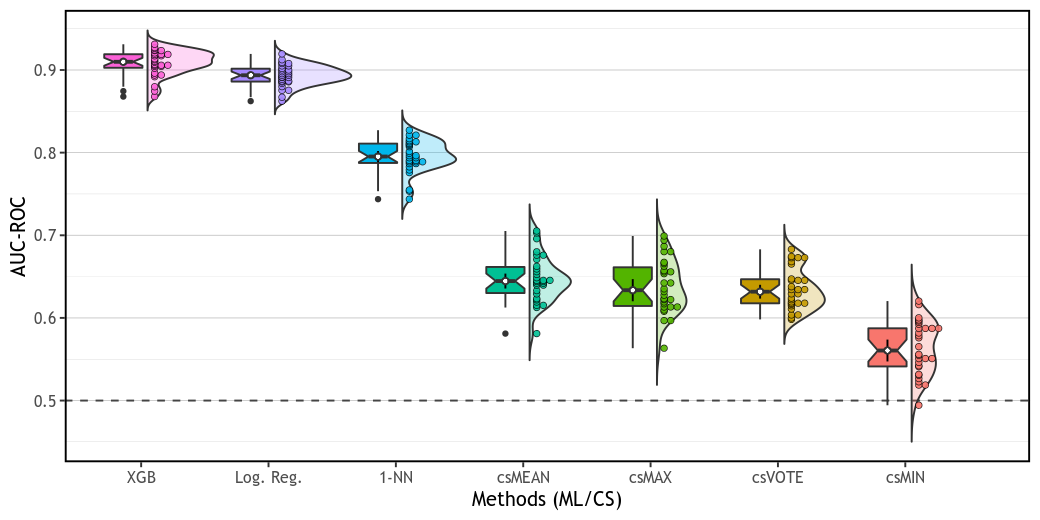

In [29]:
%%R -i df_Rmelted -i df_R -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_swarm_box(df_R, cbbPalette)

#### Critical Differences plot

    csMIN    csVOTE     csMAX    csMEAN      1-NN Log. Reg.       XGB 
"#F8766D" "#C49A00" "#53B400" "#00C094" "#00B6EB" "#A58AFF" "#FB61D7" 


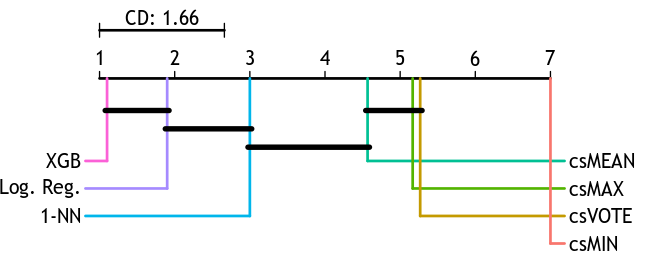

In [21]:
%%R -i df_R -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

# colnames(df_) <- c('csMAX', 'csMEAN', 'csMIN', 'csVOTE', '1-NN', 'Log. Reg.', 'XGB')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)
print(cbbPalette)

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

In [22]:
# import matplotlib as mpl
# mpl.rcParams['font.serif'] = ['Times New Roman']
# sns.set(font_scale=1.2)
# plot_cd(ho30_auc, width=9)

#### p-values heatmap

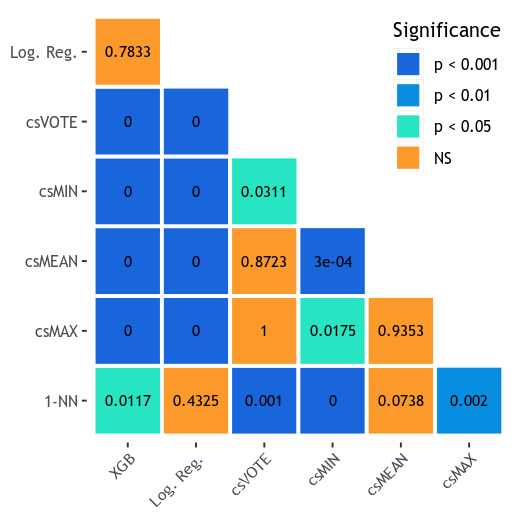

In [28]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Y-randomization test

In [24]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [25]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 15.1 ms


In [26]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)

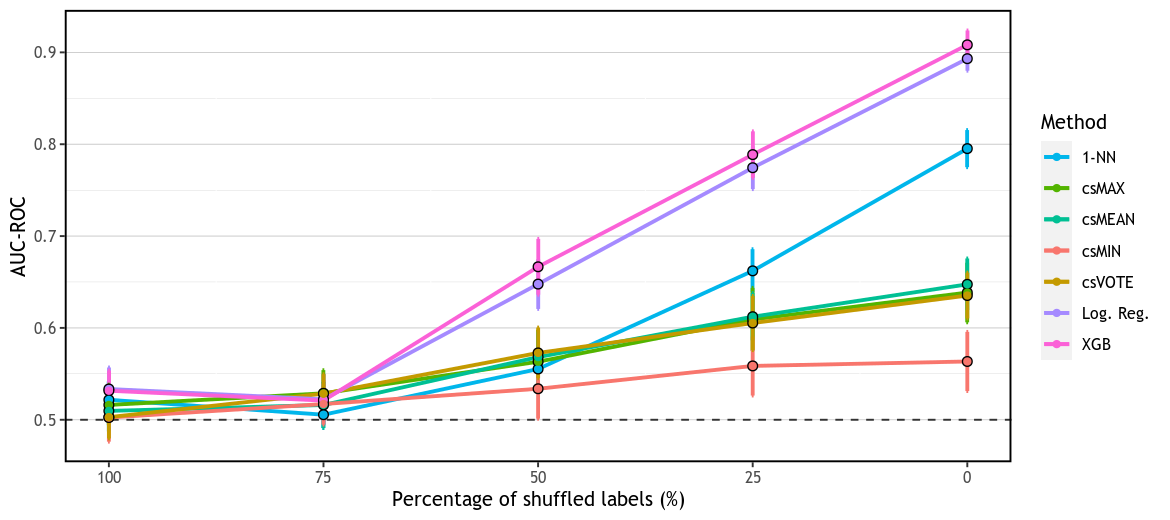

In [27]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette)